## Learning Language Models

### Learning about Attention - By Hand

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import gensim
from nltk.data import find
import nltk

nltk.download("word2vec_sample")

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     C:\Users\I745352\AppData\Roaming\nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


True

In [2]:
def softmax(x, axis=0):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x)/np.sum(np.exp(x))

def get_word2vec_embedding(words):
    """Function that takes in a list of words and returns a list of their embeddings, 
    based on a pretrained word2vec encoder."""
    word2vec_sample = str(find("models/word2vec_sample/pruned.word2vec.txt"))
    model = gensim.models.KeyedVectors.load_word2vec_format(
        word2vec_sample, binary=False
    )
    
    output=[]
    words_pass = []
    for word in words:
        try:
            output.append(np.array(model.word_vec(word)))
            words_pass.append(word)
        except:
            pass
    
    embeddings = np.array(output)
    del model
    return embeddings, words_pass
    

### Cross Attention
![Attention in Detail](attention_in_detail.png "Attention in Detail")

In code it is even easier, don't worry about the image above it will make sense as we evolve through the course. The really important part is the following:

$$
a_{ij} = f(h_i, s_{j})
$$

Where $a_{i,j}$ stands for the alignment of the word `h_i` with the output word `s_j`. The alignment may sound fancy, but it simply means how strongly connected those 2 words are in that sentence, like the Apple example!


The key is that the function $f$ can be anything. In the original paper, and the one we are implementing now it is the dot product, which you have probably seen before, and if not check the course I referenced before,  **Implement Natural Language Processing for Word Embedding**:

$$
a_{i,j} = dot product(h_i, s_j) = h_i^T*s_j
$$

So this means that for a given initial word, which is a row in the matrix we created, we have a Tensor of how aligned it is with that output word; we call that Tensor `c_k` or context vector.

And here comes the important stuff number 2, which is we take softmax to obtain weights, those wieghts will tell me for that input word how much weight (and importance) I should put into any output word. That is the attention matrix.

$$
z_j = softmax_k(c_{j,k})
$$

If we multiply this with the context vector of an encoder we have an empowered context memory tensor that can be fed into the decoder, as it is done in Transformers. We will implement all of this alongside this module

In [3]:
def dot_product_attention(hidden_states, previous_state):
    
    #[T,d]*[d,N] -> [T,N]
    scores = previous_state @ hidden_states.T
    w_n = softmax(scores)
    
    #[T,N]*[N,d] -> [T,d]
    c_t = w_n @ hidden_states
    
    return w_n, c_t

In [6]:
def plot_attention_weight_matrix(weight_matrix, x_ticks, y_ticks):
    """
    Function that takes in a weight matrix and plots it with custom axis ticks
    """
    plt.figure(figsize=(15,7))
    ax = sns.heatmap(weight_matrix, cmap="Blues")
    plt.xticks(np.arange(weight_matrix.shape[1])+0.5, x_ticks)
    plt.yticks(np.arange(weight_matrix.shape[0])+0.5, y_ticks)
    plt.title("Attention Matrix")
    plt.xlabel("Attention Score")
    plt.show()

### Testing on common English words

C:\Users\I745352\AppData\Local\Temp\ipykernel_27200\213628645.py:17: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(np.array(model.word_vec(word)))


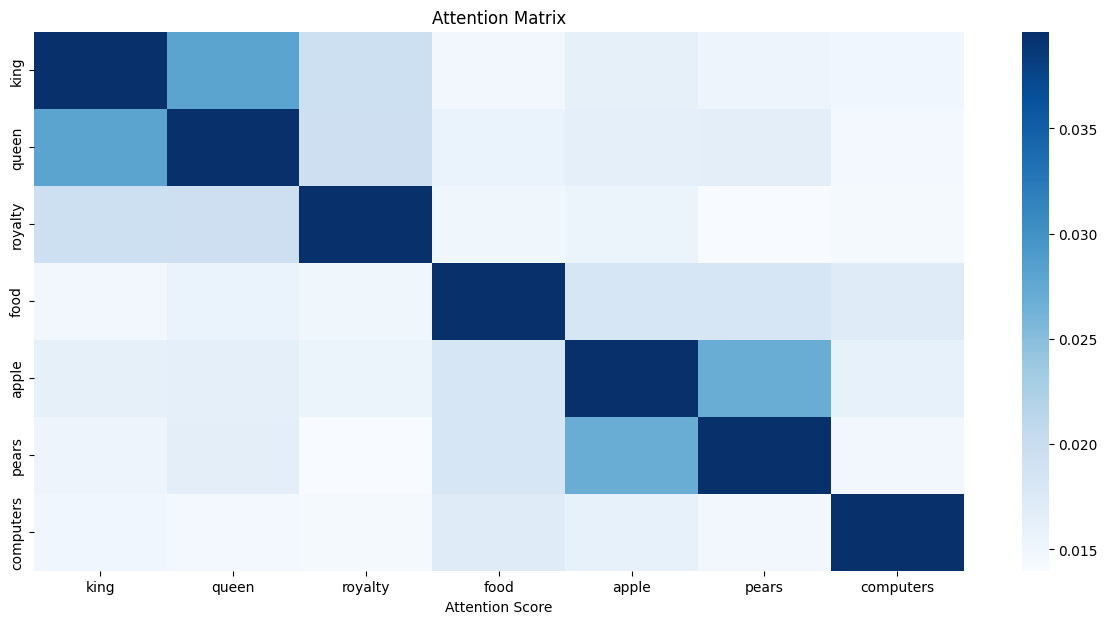

In [8]:
words = ["king", "queen", "royalty", "food", "apple", "pears", "computers"]
word_embeddings, words = get_word2vec_embedding(words)
weights, _ = dot_product_attention(word_embeddings, word_embeddings)
plot_attention_weight_matrix(weights, words, words)

## Introduction to Self-Attention

In order to get closer to the Transformer we will neeed to understand Self Attention. this concept simply relates attention with a database. In a database you have a key value pair, and with a query you get a key and with that key you return the value, right?

In self-attention ( or sometimes called  Q, K, V attention) we do the same, but instead of getting one key we will get:

$$a_{i, k} = similarity(Q_i, K_k)$$

Therefore

$$ c_i = ∑_{k}a_{i,k}*v_k $$

Which basically means we get a weighted average of **ALL** the values for every input word we want to calculate the alignment. Therefore the term self attention. The diference with the previous attention is that before the similarity function was the dot product, and the matrices `K,Q,V` where the identity (only ones in the diagonal) and here they are learneable!

In [9]:
def embed_sentence(sentence):
    """
        Embed a sentence using word2vec; for example use cases only.
    """
    
    sentence = re.sub(r"[^\w\s]","", sentence)
    words = sentence.split()
    word_vector_sequence, words = get_word2vec_embedding(words)
    return np.expand_dims(word_vector_sequence, axis=0), words

In order to see self attention, we just need to do what we did before! But now we will use a variant called **Scaled self attention** which is the one Transformers almost use:

$\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V$

In [10]:
def scaled_dot_product_attention(query, key, value):
    d_k = key.shape[-1]
    logits = query @ np.swapaxes(key,-2,-1)
    scaled_logits = logits/np.sqrt(d_k)
    attention_weights = softmax(scaled_logits, axis = -1)
    value = attention_weights @ value
    return value, attention_weights

### Testing Self Attention

In [11]:
sentence = "I drink coke, but eat steak"
word_embeddings, words = embed_sentence(sentence)
word_embeddings.shape

C:\Users\I745352\AppData\Local\Temp\ipykernel_27200\213628645.py:17: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  output.append(np.array(model.word_vec(word)))


(1, 6, 300)

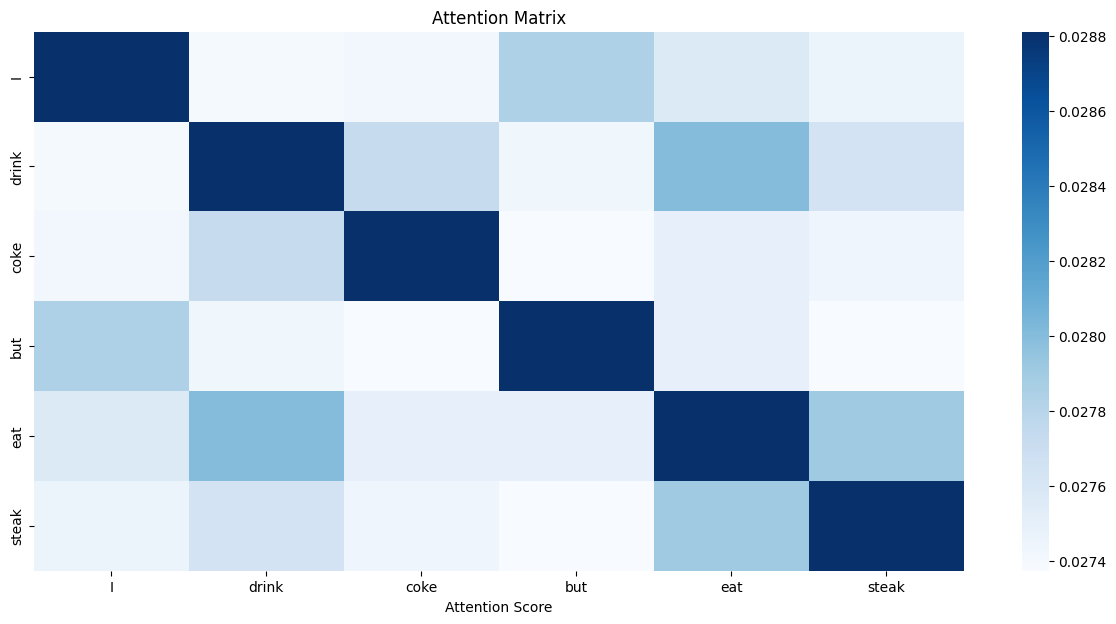

In [12]:
Q=K=V=word_embeddings

# Calculate weights and plot
values, attention_weights = scaled_dot_product_attention(Q,K,V)
words = re.sub(r"[^\w\s]","",sentence).split()
plot_attention_weight_matrix(attention_weights[0], words, words )